# RGB 转 YUV

参考：[imgproc_color_conversions](https://docs.opencv.org/4.10.0/de/d25/imgproc_color_conversions.html)

## RGB 与 YUV 之间的转换采用子采样技术

从 RGB 色彩空间转换为 YUV 色彩空间过程中，图像的每个像素的颜色信息被分解为亮度（Y）和色度（U、V）两个分量。

首先，它指出只支持 8 位值，这意味着每个颜色通道的值范围是 $0$ 到 $255$。然后，它提到了 BT.601 标准，这是一种用于定义数字视频格式的标准，其中包括了 YUV 颜色空间的定义。在这个标准中，$Y$ 的范围是 $[16, 235]$，$U$ 和 $V$ 的范围是 $[16, 240]$，并且这些值的中心点都在 $128$。

接下来，它描述了两种子采样方案：4:2:0 （YUV420P/YUV420SP，(Fourcc codes NV12, NV21, YV12, I420 and synonimic) ）和 4:2:2（(Fourcc codes UYVY, YUY2, YVYU and synonimic)）。

在两种子采样方案中，每个像素都写入 Y 值，因此 Y 平面实际上是源图像缩放和偏移的灰度版本。

在 4:2:0 方案中，U 和 V 值是在 2x2 的方块上取平均的，也就是说每四个像素只保存一个 U 值和一个 V 值。U 和 V 值交错保存在一个单独的平面（NV12, NV21）或者两个分开的半平面（YV12, I420）中。

在 4:2:2 方案中，U 和 V 值是每两个像素水平平均的，即每两个像素只保存一个 U 值和一个 V 值。根据其 Fourcc 代码，U 和 V 值与两个像素的 Y 值交错保存。

不同的转换可能会使用不同的精度来进行计算，这主要是为了提高速度或保持兼容性。例如，RGB 到 YUV 4:2:2 的转换使用了 14 位定点算术，而其他转换则使用了 20 位。请注意，为了速度或兼容性的目的，不同的转换采用不同的精度执行。例如，RGB 到 YUV 4:2:2 的转换使用 14 位定点运算进行，而其他转换则使用 20 位。

$$
\begin{align}
&R \leftarrow 1.164 \cdot (Y - 16) + 1.596 \cdot (V - 128) \\
&G \leftarrow 1.164 \cdot (Y - 16) - 0.813 \cdot (V - 128) - 0.391 \cdot (U - 128)\\
&B \leftarrow 1.164 \cdot (Y - 16) + 2.018 \cdot (U - 128)
\end{align}
$$

$$
\begin{align}
&Y \leftarrow (R \cdot 0.299 + G \cdot 0.587 + B \cdot 0.114) \cdot \frac{236 - 16}{256} + 16 \\
&U \leftarrow -0.148 \cdot R_{avg} - 0.291 \cdot G_{avg} + 0.439 \cdot B_{avg} + 128 \\
&V \leftarrow  0.439 \cdot R_{avg} - 0.368 \cdot G_{avg} - 0.071 \cdot B_{avg} + 128
\end{align}
$$

参考：[Color conversion: RGB => NV12 / NV21](https://github.com/opencv/opencv/issues/22514)

```{tip}
**cv2.COLOR_RGB2YUV_I420 是用于将 RGB 图像转换为 YUV420P 格式的颜色空间转换代码**。

在 OpenCV 中，`cv2.COLOR_RGB2YUV_I420` 是一个常量，它指示函数如 `cvtColor` 应该如何将 RGB 图像转换为 YUV 格式。具体来说，`I420` 是一种 YUV 格式，其中 Y、U 和 V 分量是分开存储的，且 U 和 V 分量相对于 Y 分量下采样（即每个 2x2 的 Y 块只有一个 U 和 V 样本）。这种格式也被称为 YUV420P。

YUV420P 是一种计划式（planar）YUV 格式，其中 Y、U、V 三个分量分别存储在不同的连续内存区域。"420" 表示 U 和 V 分量的采样率相对于 Y 分量降低了一半，即每个 U 和 V 样本对应于 4 个 Y 样本（2x2 方块），这就是所谓的 4:2:0 的采样模式。

总结联系与区别：

1. **联系**：
   - `cv2.COLOR_RGB2YUV_I420` 用于将 RGB 图像转换为 YUV420P 格式。
   - 都遵循 4:2:0 的色度采样模式，即 U 和 V 分量相对于 Y 分量下采样。

2. **区别**：
   - `cv2.COLOR_RGB2YUV_I420` 是一个转换代码，用于 OpenCV 中的 `cvtColor` 函数，而 YUV420P 是转换的结果格式。
   - YUV420P 指的是一种具体的数据存储格式，而 `cv2.COLOR_RGB2YUV_I420` 是实现这种格式转换的方法之一。

在视频处理和传输领域，YUV420P 格式非常常见，因为它能够在保持较高图像质量的同时减少数据量。使用 `cv2.COLOR_RGB2YUV_I420` 转换代码是实现 RGB 到 YUV420P 转换的一种简便方法。
```

In [1]:
from PIL import Image
import numpy as np
import cv2

def bgr2nv12(bgr: np.ndarray) -> np.ndarray:
    yuv = cv2.cvtColor(bgr, cv2.COLOR_BGR2YUV_I420) # YUV420P
    uv_row_cnt = yuv.shape[0] // 3
    uv_plane = np.transpose(yuv[uv_row_cnt * 2:].reshape(2, -1), [1, 0])
    yuv[uv_row_cnt * 2:] = uv_plane.reshape(uv_row_cnt, -1)
    return yuv

def bgr2nv21(bgr:np.ndarray) -> np.ndarray:
    yuv = cv2.cvtColor(bgr, cv2.COLOR_BGR2YUV_YV12)
    uv_row_cnt = yuv.shape[0] // 3
    uv_plane = np.transpose(yuv[uv_row_cnt * 2:].reshape(2, -1), [1, 0])
    yuv[uv_row_cnt * 2:] = uv_plane.reshape(uv_row_cnt, -1)
    return yuv

In [2]:
path = "../vta/images/cat.jpg"
bgr = cv2.imread(path)
yuv_image = bgr2nv12(bgr)
bgr.shape, yuv_image.shape, 

((256, 256, 3), (384, 256))

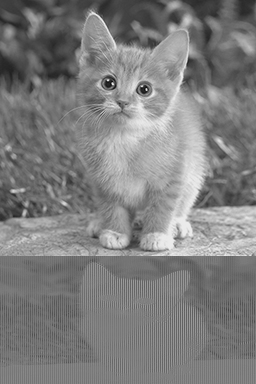

In [3]:
Image.fromarray(yuv_image)

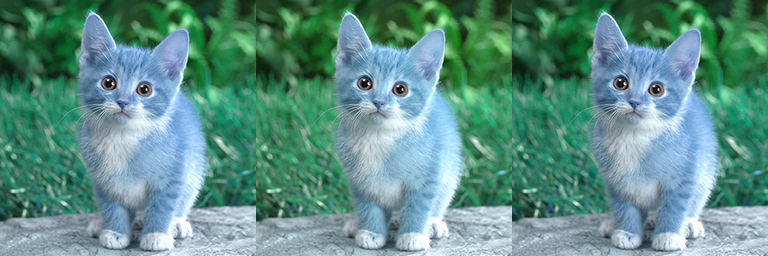

In [4]:
yuv_nv12 = cv2.cvtColor(bgr2nv12(bgr), cv2.COLOR_YUV420SP2RGB)
yuv_nv21 =cv2.cvtColor(bgr2nv21(bgr), cv2.COLOR_YUV420SP2BGR)
Image.fromarray(np.concatenate([bgr, yuv_nv12, yuv_nv21], axis=1))

In [5]:
from PIL import Image
import numpy as np
import cv2

def rgb2nv12(rgb: np.ndarray) -> np.ndarray:
    yuv = cv2.cvtColor(rgb, cv2.COLOR_RGB2YUV_I420) # YUV420P 交错 UV
    uv_row_cnt = yuv.shape[0] // 3
    uv_plane = np.transpose(yuv[uv_row_cnt * 2:].reshape(2, -1), [1, 0]) # 交错 UV
    yuv[uv_row_cnt * 2:] = uv_plane.reshape(uv_row_cnt, -1)
    return yuv

def rgb2nv21(rgb:np.ndarray) -> np.ndarray:
    yuv = cv2.cvtColor(rgb, cv2.COLOR_RGB2YUV_YV12) # YUV420P 交错 VU
    uv_row_cnt = yuv.shape[0] // 3
    uv_plane = np.transpose(yuv[uv_row_cnt * 2:].reshape(2, -1), [1, 0]) # 交错 VU
    yuv[uv_row_cnt * 2:] = uv_plane.reshape(uv_row_cnt, -1)
    return yuv

In [6]:
path = "../vta/images/cat.jpg"
rgb = np.array(Image.open(path).resize((112, 112)))
yuv_image = rgb2nv12(rgb)
rgb.shape, yuv_image.shape, 

((112, 112, 3), (168, 112))

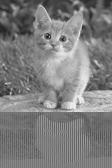

In [7]:
Image.fromarray(yuv_image)

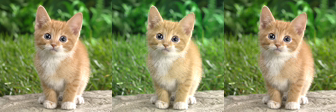

In [8]:
yuv_nv12 = cv2.cvtColor(rgb2nv12(rgb), cv2.COLOR_YUV420SP2BGR)
yuv_nv21 =cv2.cvtColor(rgb2nv21(rgb), cv2.COLOR_YUV420SP2RGB)
Image.fromarray(np.concatenate([rgb, yuv_nv12, yuv_nv21], axis=1))